In [9]:
import os
import copy
import cv2
import glob
import random
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision.transforms as transforms
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms.functional import to_pil_image

In [10]:
EXTENSION = ".mp4"
FRAMES = 16
BATCH_SIZE = 4
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {DEVICE} device')

Using cpu device


In [11]:
def get_vids(path2dataset):
    listOfCats = os.listdir(path2dataset)
    ids = []
    labels = []
    for catg in listOfCats:
        path2catg = os.path.join(path2dataset, catg)
        listOfSubCats = os.listdir(path2catg)
        path2subCats= [os.path.join(path2catg, vid) for vid in listOfSubCats]
        ids.extend(path2subCats)
        if catg == 'negative_samples':
            catg = 'No_Accident_Detected'
        else:
            catg = 'Accident_Detected'
        labels.extend([catg]*len(listOfSubCats))
    return ids, labels

In [12]:
def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)
    return x

In [13]:
def get_frames(filename, n_frames= 1): #using vlms
    v_cap = cv2.VideoCapture(filename)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    height = v_cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    if height != 720:
        return [], v_len, False
    fps = v_cap.get(cv2.CAP_PROP_FPS)
    duration = v_len/fps
    if duration<3 or duration>16:
        return [], v_len, False
    frames = []
    frame_list= np.linspace(0, v_len-1, n_frames+1, dtype=np.int16)
    for fn in range(v_len):
        success, frame = v_cap.read()
        if success is False:
            continue
        if (fn in frame_list):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    v_cap.release()
    return frames, v_len, True

In [14]:
def transform_frames(frames, model_type="rnn"):
    if model_type == "rnn":
        h, w = 224, 224
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        h, w = 112, 112
        mean = [0.43216, 0.394666, 0.37645]
        std = [0.22803, 0.22145, 0.216989]

    test_transformer = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])

    frames_tr = []
    for frame in frames:
        frame = Image.fromarray(frame)
        frame_tr = test_transformer(frame)
        frames_tr.append(frame_tr)
    imgs_tensor = torch.stack(frames_tr)

    if model_type=="3dcnn":
        imgs_tensor = torch.transpose(imgs_tensor, 1, 0)
    imgs_tensor = imgs_tensor.unsqueeze(0)
    return imgs_tensor


In [15]:
def store_frames(frames, path2store):
    for ii, frame in enumerate(frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        path2img = os.path.join(path2store, "frame"+str(ii)+".jpg")
        cv2.imwrite(path2img, frame)



In [17]:
path2data = "/content/drive/MyDrive/Video-Accident-Dataset"
path2dataset = "/content/drive/MyDrive/Video-Accident-Dataset"
path2Cats = path2data
Categories = os.listdir(path2Cats)
Categories

['head_on_collision',
 'fire_or_explosions',
 'collision_with_motorcycle',
 'objects_falling',
 'negative_samples',
 'pedestrian_hit',
 'collision_with_stationary_object',
 'drifting_or_skidding',
 'side_collision',
 'rollover',
 'rear_collision',
 'other_crash',
 '.ipynb_checkpoints']

In [18]:
for cat in Categories:
    print("Category:", cat)
    path2acat = os.path.join(path2Cats, cat)
    listOfSubs = os.listdir(path2acat)
    print("No of Videos:", len(listOfSubs))
    print("-"*50)

Category: head_on_collision
No of Videos: 155
--------------------------------------------------
Category: fire_or_explosions
No of Videos: 56
--------------------------------------------------
Category: collision_with_motorcycle
No of Videos: 331
--------------------------------------------------
Category: objects_falling
No of Videos: 77
--------------------------------------------------
Category: negative_samples
No of Videos: 1894
--------------------------------------------------
Category: pedestrian_hit
No of Videos: 22
--------------------------------------------------
Category: collision_with_stationary_object
No of Videos: 319
--------------------------------------------------
Category: drifting_or_skidding
No of Videos: 366
--------------------------------------------------
Category: side_collision
No of Videos: 270
--------------------------------------------------
Category: rollover
No of Videos: 258
--------------------------------------------------
Category: rear_collisio

In [19]:
for root, dirs, files in os.walk(path2Cats, topdown=True):
    if len(dirs) == 0:
        cat = root.split('/')[-1]
        cnt = 0
        for name in files:
            if EXTENSION not in name:
                continue
            path2vid = os.path.join(root, name)
            frames, vlen, chk = get_frames(path2vid, n_frames= FRAMES)
            if not chk:
                continue
            cnt += 1
            path2store = path2vid.replace(path2data, path2dataset)
            path2store = path2store.replace(name, name.split("_")[-1].split(".")[0])
            #print(path2store)
            os.makedirs(path2store, exist_ok= True)
            store_frames(frames, path2store)
        print(f'Category: {cat}\nVideos converted into Frames: {cnt}')
        print("-"*50)

Category: 102
Videos converted into Frames: 0
--------------------------------------------------
Category: 10
Videos converted into Frames: 0
--------------------------------------------------
Category: 11
Videos converted into Frames: 0
--------------------------------------------------
Category: 12
Videos converted into Frames: 0
--------------------------------------------------
Category: 1
Videos converted into Frames: 0
--------------------------------------------------
Category: 14
Videos converted into Frames: 0
--------------------------------------------------
Category: 13
Videos converted into Frames: 0
--------------------------------------------------
Category: 22
Videos converted into Frames: 0
--------------------------------------------------
Category: 16
Videos converted into Frames: 0
--------------------------------------------------
Category: 18
Videos converted into Frames: 0
--------------------------------------------------
Category: 17
Videos converted into Frame

In [20]:
all_vids, all_labels = get_vids(path2dataset)
len(all_vids), len(all_labels)

(3998, 3998)

In [21]:
all_vids[:60], all_labels[:60]

(['/content/drive/MyDrive/Video-Accident-Dataset/head_on_collision/head_on_collision_102.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/head_on_collision/head_on_collision_101.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/head_on_collision/head_on_collision_100.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/head_on_collision/head_on_collision_10.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/head_on_collision/head_on_collision_1.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/head_on_collision/head_on_collision_106.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/head_on_collision/head_on_collision_104.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/head_on_collision/head_on_collision_110.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/head_on_collision/head_on_collision_109.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/head_on_collision/head_on_collision_103.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/head

In [22]:
labels_dict = {'Accident_Detected': 1, 'No_Accident_Detected': 0}
labels_dict

{'Accident_Detected': 1, 'No_Accident_Detected': 0}

In [23]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
# Splitting `all_vids` (video paths) and `all_labels` (corresponding labels)

# Perform the initial train-test split with a test size of 25%
x_train, x_test, y_train, y_test = train_test_split(all_vids, all_labels, test_size=0.25, random_state=42, stratify=all_labels)

# Perform a second split on the training set to create a validation set with a size of 15% of the initial training set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=42, stratify=y_train)


In [24]:
np.unique(y_train, return_counts=True)

(array(['Accident_Detected', 'No_Accident_Detected'], dtype='<U20'),
 array([1341, 1207]))

In [25]:
np.unique(y_val, return_counts=True)

(array(['Accident_Detected', 'No_Accident_Detected'], dtype='<U20'),
 array([237, 213]))

In [26]:
np.unique(y_test, return_counts=True)

(array(['Accident_Detected', 'No_Accident_Detected'], dtype='<U20'),
 array([526, 474]))

In [27]:
x_train[:50], y_train[:50]

(['/content/drive/MyDrive/Video-Accident-Dataset/negative_samples/negative_samples_765.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/head_on_collision/head_on_collision_55.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/collision_with_motorcycle/13',
  '/content/drive/MyDrive/Video-Accident-Dataset/negative_samples/606',
  '/content/drive/MyDrive/Video-Accident-Dataset/head_on_collision/head_on_collision_3.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/collision_with_motorcycle/collision_with_motorcycle_21.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/negative_samples/297',
  '/content/drive/MyDrive/Video-Accident-Dataset/collision_with_motorcycle/collision_with_motorcycle_160.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/other_crash/other_crash_35.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/drifting_or_skidding/drifting_or_skidding_44.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/negative_samples/negative_samples_584.mp4',


In [28]:
x_val[:50], y_val[:50]

(['/content/drive/MyDrive/Video-Accident-Dataset/negative_samples/negative_samples_697.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/negative_samples/negative_samples_695.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/collision_with_stationary_object/collision_with_stationary_object_129.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/negative_samples/negative_samples_309.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/side_collision/side_collision_189.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/negative_samples/267',
  '/content/drive/MyDrive/Video-Accident-Dataset/rear_collision/rear_collision_132.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/negative_samples/negative_samples_735.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/negative_samples/271',
  '/content/drive/MyDrive/Video-Accident-Dataset/drifting_or_skidding/drifting_or_skidding_12.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/rear_collision/rear_collision_26

In [29]:
x_test[:50], y_test[:50]

(['/content/drive/MyDrive/Video-Accident-Dataset/negative_samples/negative_samples_35.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/drifting_or_skidding/drifting_or_skidding_17.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/collision_with_motorcycle/collision_with_motorcycle_35.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/collision_with_stationary_object/143',
  '/content/drive/MyDrive/Video-Accident-Dataset/drifting_or_skidding/drifting_or_skidding_2.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/negative_samples/negative_samples_682.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/negative_samples/1',
  '/content/drive/MyDrive/Video-Accident-Dataset/negative_samples/501',
  '/content/drive/MyDrive/Video-Accident-Dataset/rear_collision/rear_collision_149.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/collision_with_stationary_object/collision_with_stationary_object_116.mp4',
  '/content/drive/MyDrive/Video-Accident-Dataset/negative_samp

In [44]:
import numpy as np
import random
import torch
from torch.utils.data import Dataset
from PIL import Image
import glob

# Set random seeds for reproducibility across different libraries
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Define a custom dataset class for handling video data
class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):
        self.transform = transform  # Transformation to apply to each frame
        self.ids = ids  # List of video paths
        self.labels = labels  # List of corresponding labels

    def __len__(self):
        return len(self.ids)  # Return the number of videos in the dataset

    def __getitem__(self, idx):
        # Get a list of paths to image frames in the current video
        path2imgs = glob.glob(self.ids[idx] + "/*.jpg")
        path2imgs = path2imgs[:FRAMES]  # Limit to FRAMES number of frames
        label = labels_dict[self.labels[idx]]  # Get the numeric label corresponding to the video label

        frames = []
        # Load each frame from its path
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frames.append(frame)

        # Return None if no frames were loaded
        if len(frames) == 0:
            return None

        # Generate a random seed for data augmentation
        seed = np.random.randint(1e9)

        frames_tr = []
        # Apply transformation to each frame
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)

        # Stack transformed frames into a tensor
        if len(frames_tr) > 0:
            frames_tr = torch.stack(frames_tr)

        return frames_tr, label

In [31]:
model_type = "rnn"

# Set parameters based on the model_type variable
if model_type == "rnn":
    h, w = 224, 224  # Image height and width for RNN model
    mean = [0.485, 0.456, 0.406]  # Mean normalization values for RNN model
    std = [0.229, 0.224, 0.225]   # Standard deviation normalization values for RNN model
else:
    h, w = 112, 112  # Image height and width for other models (if applicable)
    mean = [0.43216, 0.394666, 0.37645]  # Mean normalization values for other models (if applicable)
    std = [0.22803, 0.22145, 0.216989]   # Standard deviation normalization values for other models (if applicable)


In [32]:
from torchvision import transforms

# h, w, mean, std are defined based on the model_type

trainTransform = transforms.Compose([
    transforms.Resize((h, w)),  # Resize images to (h, w) dimensions
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally with a probability of 50%
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Apply random affine transformation with translation
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean, std),  # Normalize the image with mean and standard deviation
])


In [33]:
trainDs = VideoDataset(ids=x_train, labels=y_train, transform=trainTransform)
len(trainDs)

2548

In [34]:
imgs, label = trainDs[5]

for img in imgs:
    print(img.shape)
    flattened_img = img.view(-1)
    min_value = torch.min(flattened_img)
    max_value = torch.max(flattened_img)
    print(f"Min value: {min_value}, Max value: {max_value}")

In [35]:
# imgs, label = trainDs[9]
# imgs.shape, label, torch.min(imgs), torch.max(imgs)
# Code with error replaced with above code

In [36]:
import matplotlib.pyplot as plt

# Assuming imgs is a list of images (tensors) you want to visualize, denormalize function is defined, mean and std are defined

plt.figure(figsize=(20, 20))  # Set the size of the figure

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Iterate over the images, showing every fifth image
for ii, img in enumerate(imgs[::2]):
    plt.subplot(1, 10, ii + 2)  # Create a subplot for each image
    plt.imshow(denormalize(img, mean, std))  # Denormalize and display the image
    plt.axis("off")  # Turn off the axis labels

plt.show()  # Display the plot


<Figure size 2000x2000 with 0 Axes>

In [37]:
# Define the transformation pipeline for validation and test datasets
testTransform = transforms.Compose([
    transforms.Resize((h, w)),  # Resize images to (h, w) dimensions
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean, std),  # Normalize the image with mean and standard deviation
])

# Create validation dataset (valDs) and test dataset (testDs) using VideoDataset
valDs = VideoDataset(ids=x_val, labels=y_val, transform=testTransform)
testDs = VideoDataset(ids=x_test, labels=y_test, transform=testTransform)

# Get the lengths of the validation and test datasets
len(valDs), len(testDs)


(450, 1000)

In [38]:
import matplotlib.pyplot as plt
imgs, label = testDs[9]

# Plotting setup
plt.figure(figsize=(20, 20))  # Set the size of the figure

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Iterate over the images, showing every fifth image
for ii, img in enumerate(imgs[::3]):
    plt.subplot(1, 10, ii + 1)  # Create a subplot for each image
    plt.imshow(denormalize(img, mean, std))  # Denormalize and display the image
    plt.axis("on")  # Turn off the axis labels

plt.show()  # Display the plot

<Figure size 2000x2000 with 0 Axes>

In [39]:
def collateRNN(batch):
    # Unzip the batch into lists of images and labels
    imgs_batch, label_batch = list(zip(*batch))

    # Filter out empty image batches (length zero)
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs) > 0]

    # Filter labels corresponding to non-empty image batches and convert to tensor
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs) > 0] # Filter labels to match

    # Stack the non-empty image batches into a single tensor
    imgs_tensor = torch.stack(imgs_batch)

    # Stack the corresponding labels into a single tensor
    labels_tensor = torch.stack(label_batch)

    return imgs_tensor, labels_tensor


In [40]:
# Create DataLoader for training dataset (trainDL)
trainDL = DataLoader(trainDs,
                     batch_size=BATCH_SIZE,  # Number of samples per batch
                     shuffle=True,           # Shuffle the data at every epoch
                     num_workers=2,          # Number of subprocesses to use for data loading
                     collate_fn=collateRNN)  # Function to collate batches of data

# Create DataLoader for validation dataset (valDL)
valDL = DataLoader(valDs,
                   batch_size=BATCH_SIZE,   # Number of samples per batch
                   shuffle=True,            # Shuffle the data at every epoch
                   num_workers=2,           # Number of subprocesses to use for data loading
                   collate_fn=collateRNN)   # Function to collate batches of data

# Create DataLoader for test dataset (testDL)
testDL = DataLoader(testDs,
                    batch_size=2 * BATCH_SIZE,  # Number of samples per batch (larger batch size for testing)
                    shuffle=False,             # Do not shuffle the data for testing
                    collate_fn=collateRNN)      # Function to collate batches of data


In [41]:
def collateRNN(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor, labels_tensor

In [45]:
def collateRNN(batch):
    # Filter out None values from the batch
    batch = [item for item in batch if item is not None]

    # If the batch is empty after filtering, return None for both images and labels
    if len(batch) == 0:
        return None, None

    imgs_batch, label_batch = zip(*batch)
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor, labels_tensor

trainDL = DataLoader(trainDs, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collateRNN)
valDL = DataLoader(valDs, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collateRNN)
testDL = DataLoader(testDs, batch_size=1*BATCH_SIZE, shuffle=False, collate_fn=collateRNN)

In [46]:
for xb, yb in trainDL:
    print(xb.shape, yb.shape)
    break
for xb, yb in valDL:
    print(xb.shape, yb.shape)
    break
for xb, yb in testDL:
    print(xb.shape, yb.shape)
    break

torch.Size([1, 16, 3, 224, 224]) torch.Size([1])


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-45-1854945500.py", line 12, in collateRNN
    imgs_tensor = torch.stack(imgs_batch)
                  ^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: stack expects a non-empty TensorList


In [47]:
from torchvision.models import ResNet18_Weights

class Resnt18Rnn(nn.Module):
    def __init__(self, params_model):
        super(Resnt18Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate = params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]

        baseModel = models.resnet18(pretrained=pretrained)
        num_ftrs = baseModel.fc.in_features
        baseModel.fc = nn.Identity()  # Remove the final fully connected layer of ResNet18

        self.baseModel = baseModel
        self.dropout = nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_ftrs, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state with correct dimensions
        hn = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(DEVICE)
        cn = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(DEVICE)

        ts = x.shape[1]  # Number of images in the sequence
        for ii in range(ts):
            y = self.baseModel(x[:, ii])  # Pass through ResNet18
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))  # Pass through LSTM

        out = self.dropout(out[:, -1])  # Apply dropout to the last LSTM output
        out = self.fc1(out)  # Pass through final fully connected layer
        return out

# Define Identity module to return input as-is
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


In [48]:
# Define parameters for the Resnt18Rnn model
params_model = {
    "num_classes": 2,           # Number of output classes (binary classification)
    "dr_rate": 0.1,             # Dropout rate (to prevent overfitting)
    "pretrained": True,         # Use pre-trained ResNet18 weights
    "rnn_num_layers": 1,        # Number of LSTM layers
    "rnn_hidden_size": 100,     # Size of LSTM hidden state
}

# Initialize Resnt18Rnn model with specified parameters and move to DEVICE (GPU if available)
model = Resnt18Rnn(params_model).to(DEVICE)

# Print model architecture summary
print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.9MB/s]


Resnt18Rnn(
  (baseModel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [49]:
# Context: Assuming 'h' and 'w' are defined earlier based on model initialization or data preprocessing.

# Run inference with no gradient computation
with torch.no_grad():
    # Create a dummy input tensor 'x' with shape (batch_size=1, time_steps=16, channels=3, height=h, width=w)
    x = torch.zeros(1, 16, 3, h, w).to(DEVICE)

    # Pass the input tensor through the model to get the output 'y'
    y = model(x)

    # Print the shape of the output tensor 'y'
    print(y.shape)


torch.Size([1, 2])


In [50]:
import os

# Define the file path where the model weights will be saved
path2weights = "/content/drive/MyDrive/Accident-Dataset-Keyframes/working/weights.pt"  # Save in the current directory

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(path2weights), exist_ok=True)

# Save the state dictionary of the model to the specified file path
torch.save(model.state_dict(), path2weights)

In [51]:
# Define the file path where the model weights will be saved
# path2weights = "/kaggle/working/weights.pt"

# Save the state dictionary of the model to the specified file path
# torch.save(model.state_dict(), path2weights)


In [52]:
# Function to retrieve current learning rate from optimizer
import tqdm.notebook
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to calculate number of correct predictions in a batch
def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

# Function to compute loss and metrics for a batch and perform backpropagation if optimizer is provided
def loss_batch(loss_func, output, target, opt=None):
    # Compute loss
    loss = loss_func(output, target)

    # Calculate metrics (number of correct predictions)
    with torch.no_grad():
        metric_b = metrics_batch(output, target)

    # Perform backpropagation if optimizer is provided
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Function to compute loss and metrics for an entire epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    # Iterate over batches in the dataset
    for xb, yb in tqdm.notebook.tqdm(dataset_dl):
        xb = xb.to(DEVICE)  # Move inputs to device (GPU or CPU)
        yb = yb.to(DEVICE)  # Move labels to device

        # Forward pass through the model
        output = model(xb)

        # Compute batch loss and metrics
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        # Accumulate running loss and metrics
        running_loss += loss_b
        if metric_b is not None:
            running_metric += metric_b

        # Optionally break loop for debugging (sanity check)
        if sanity_check is True:
            break

    # Compute average epoch loss and metrics
    loss = running_loss / float(len_data)
    metric = running_metric / float(len_data)

    return loss, metric

# Function to train and validate the model over multiple epochs
def train_val(model, params):
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    sanity_check = params["sanity_check"]
    lr_scheduler = params["lr_scheduler"]
    path2weights = params["path2weights"]

    # Initialize empty dictionaries to store training history
    loss_history = {"train": [], "val": []}
    metric_history = {"train": [], "val": []}

    # Deep copy of model weights and initial best loss
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    # Main training loop over epochs
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)  # Get current learning rate from optimizer
        print('Epoch {}/{}, Current Learning Rate={}'.format(epoch, num_epochs - 1, current_lr))

        # Set model to training mode
        model.train()

        # Train the model for one epoch and compute training loss and metrics
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        # Set model to evaluation mode
        model.eval()

        # Evaluate the model on validation set and compute validation loss and metrics
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)

        # Save best model weights if validation loss improves
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")

        # Record validation loss and metrics
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # Adjust learning rate based on validation loss
        lr_scheduler.step(val_loss)

        # Reload best model weights if learning rate changes
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        # Print epoch summary
        print("Train loss: %.6f, Validation loss: %.6f, Accuracy: %.2f" % (train_loss, val_loss, 100 * val_metric))
        print("-" * 50)

    # Load best model weights before returning
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history


In [53]:
def plot_loss(loss_hist, metric_hist):
    num_epochs = len(loss_hist["train"])  # Get the number of epochs from the training history

    # Plotting training and validation loss
    plt.title("Train-Val Loss")
    plt.plot(range(1, num_epochs + 1), loss_hist["train"], label="Train")  # Plot training loss
    plt.plot(range(1, num_epochs + 1), loss_hist["val"], label="Val")      # Plot validation loss
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    # Plotting training and validation accuracy
    plt.title("Train-Val Accuracy")
    plt.plot(range(1, num_epochs + 1), metric_hist["train"], label="Train")  # Plot training accuracy
    plt.plot(range(1, num_epochs + 1), metric_hist["val"], label="Val")      # Plot validation accuracy
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()


In [54]:
#after this cell there are errors so pls dont change the above code

In [55]:
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=0.00085)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5,verbose=1)
os.makedirs("/Accident-Dataset-Keyframes/weights.pt", exist_ok=True)

params_train={
    "num_epochs": 50,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": trainDL,
    "val_dl": valDL,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": "/Accident-Dataset-Keyframes/working/weights"+model_type+".pt",
}



/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [56]:

# # Verify the data loader by printing out the contents of a few batches
# for i, batch in enumerate(testDL):
#     print(f"Batch {i}: {batch}")
#     if i >= 2:  # Print first 3 batches only for verification
#         break


In [57]:
# Verify the data loader by printing out the contents of a few batches
for i, batch in enumerate(testDL):
    print(f"Batch {i}: {batch}")
    if i >= 2:  # Print first 3 batches only for verification
        break

def collateRNN(batch):
    # Unpack the batch
    imgs_batch, label_batch = zip(*batch)

    # Filter out invalid entries
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs) > 0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs) > 0]

    # Check if the batch is empty after filtering
    if not imgs_batch or not label_batch:
        return None, None

    # Stack the tensors
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)

    return imgs_tensor, labels_tensor


RuntimeError: stack expects a non-empty TensorList

In [58]:
def collateRNN(batch):
    imgs_batch, label_batch = zip(*batch)

    # Ensure all items in imgs_batch are tensors
    imgs_batch = [torch.stack([torch.tensor(img) if isinstance(img, np.ndarray) else img for img in imgs]) for imgs in imgs_batch]

    # Ensure label_batch is properly converted to tensors
    label_batch = [torch.tensor(l) for l in label_batch]

    # Debug prints
    print(f"Processed imgs_batch types: {[type(imgs) for imgs in imgs_batch]}")
    print(f"Processed label_batch types: {[type(label) for label in label_batch]}")

    # Check for empty lists
    if not imgs_batch or not label_batch:
        return None, None

    # Convert lists of tensors to single tensors
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor, labels_tensor


In [59]:
class DummyDataset(Dataset):
    def __init__(self):
        # Dummy data: List of tuples, where each tuple contains a list of tensors and a label
        self.data = [([torch.randn(3, 224, 224)] * 16, 1)] * 5

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dummy_dataset = DummyDataset()
dummy_loader = DataLoader(dummy_dataset, batch_size=1, collate_fn=collateRNN)

for batch in dummy_loader:
    print(batch)


Processed imgs_batch types: [<class 'torch.Tensor'>]
Processed label_batch types: [<class 'torch.Tensor'>]
(tensor([[[[[ 1.8836e+00, -9.3269e-02,  4.3418e-01,  ..., -8.0616e-01,
             1.4008e+00, -1.1979e-01],
           [ 2.1303e-03, -1.4780e+00, -5.5842e-01,  ..., -5.7487e-02,
             1.5609e+00,  2.8293e-01],
           [ 8.0341e-01, -2.7295e-01, -6.0822e-01,  ..., -4.5629e-01,
             5.0331e-01,  2.1961e-01],
           ...,
           [ 1.4683e-01,  3.2988e-01,  1.3941e+00,  ..., -1.7142e-01,
            -1.8099e-01,  3.6246e-01],
           [-1.2478e+00, -1.5254e+00, -7.5040e-01,  ...,  1.5791e-01,
            -8.5188e-01, -9.5380e-01],
           [ 7.2681e-01,  4.3484e-01,  6.2743e-01,  ..., -2.2846e+00,
            -8.0495e-01, -9.6380e-01]],

          [[ 1.0739e+00,  1.2937e-01,  2.7720e-01,  ..., -1.9376e-01,
             4.8406e-01,  6.4620e-01],
           [ 5.5727e-01,  3.1835e-01, -2.3638e-01,  ...,  2.8261e+00,
            -8.3843e-01, -8.5836e-01],
  

In [60]:
import numpy as np


#import numpy as np

# Initialize y_true and y_pred with some values.
# Replace these with your actual data.
y_true = [1, 0, 1]
y_pred = [0, 0, 1]

y_true = np.hstack(y_true)
y_pred = np.hstack(y_pred)

print(y_true)
print(y_pred)
#y_true = np.hstack(y_true)
#y_pred = np.hstack(y_pred)

[1 0 1]
[0 0 1]


In [61]:
df = pd.DataFrame((y_true, y_pred), index = ['Label', 'Prediction'])
df

,0,1,2
Label,1,0,1
Prediction,0,0,1


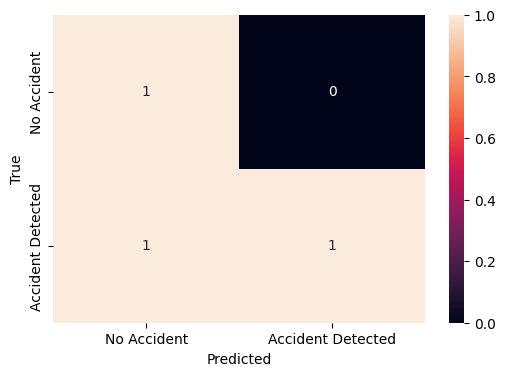

In [62]:
# Define the class labels
classes = ('No Accident', 'Accident Detected')

# Compute the confusion matrix using y_true (true labels) and y_pred (predicted labels)
cf_matrix = confusion_matrix(y_true, y_pred)

# Create a DataFrame for the confusion matrix with class labels as index and columns
df_cm = pd.DataFrame(cf_matrix, index=[i for i in classes], columns=[i for i in classes])

# Set up the figure size for the heatmap
plt.figure(figsize=(6, 4))

# Plot the heatmap using seaborn, annotating each cell with the numeric value
sns.heatmap(df_cm, annot=True, fmt="d")

# Add labels to the x and y axes
plt.xlabel('Predicted')
plt.ylabel('True')

# Display the heatmap
plt.show()


In [63]:
print("Precision:\t"+str(precision_score(y_true, y_pred)))
print("Recall:\t"+str(recall_score(y_true, y_pred)))
print("F1-Score:\t"+str(f1_score(y_true, y_pred)))
print("Accuracy:\t"+str(accuracy_score(y_true, y_pred)))

Precision:	1.0
Recall:	0.5
F1-Score:	0.6666666666666666
Accuracy:	0.6666666666666666


In [ ]:
for xb, yb in trainDL:
    print(xb.shape, yb.shape)
    break
for xb, yb in valDL:
    print(xb.shape, yb.shape)
    break
for xb, yb in testDL:
    print(xb.shape, yb.shape)
    break